In [1]:
from scipy.signal import lfilter
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from statistics import mean
from scipy import integrate
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
import statistics
import copy
from pandas import *

In [2]:
## This script is written for acc peak vs. angle comparison 
## data are all taken at depth 5 cm below the substrate surface 
## acc:     5 - F2 - F3 - 7 
## radial: 10 - 6 - 6 - 10
## radial: 12 - 8 - 8 - 12
## F2 & F3 on the GRscope; 5 & 7 on the IOscope  

In [3]:
## acc voltage to real units conversion factor
## [y1,x1,z1, y2,x2,z2]
conv_F2F3 = [0.00601427, 0.0059633, 0.0059633, 0.00606523, 0.00606523, 0.0059633]
conv_57  = [0.0328, 0.0325, 0.0322, 0.0324, 0.0328, 0.0327]

In [83]:
def pack(import_file_name, col_list, conv): # pack csv data to arrays 
    # import data using pandas
    col = ['Time', 'Channel A', 'Channel B', 'Channel C','Channel E','Channel F','Channel G'] # define columns
    data_pd = pd.read_csv(import_file_name, usecols = col_list)   # array in pandas
    # create empty output data pack 
    # data structure: [time, channel_a, channel_b, channel_c,...]
    output_datapack = np.linspace(0,0,np.size(col_list)).tolist()
    # conversion to str list
    for i in range(np.size(col_list)):
        output_datapack[i] = data_pd[col[i]][1:].tolist() 
        if i == 0: # time
            output_datapack[i] = [float("{0:.6f}".format(float(j)*1000)) for j in output_datapack[i]] # convert to float
        else:
            output_datapack[i] = [float(j) for j in output_datapack[i]]
            zero = mean(output_datapack[i][20:200]) # baseline for shifting and aligning "zero" accelerations to zero
            output_datapack[i] = [float(j-zero)/conv[i-1] for j in output_datapack[i]] # voltage to acceleration conversion
            #output_datapack[i] = [abs(j) for j in output_datapack[i]] # making all channel abs 
#             index = find_onset(output_datapack[i])
#             output_datapack[i][0:index] = np.linspace(0,0,index)
    return output_datapack

def combine_data(data_1, data_2, group_size):
    combined_data = []
    min_length = min(len(data_1), len(data_2))
    
    for i in range(0, min_length, group_size):
        combined_data.extend(data_2[i:i+group_size])
        combined_data.extend(data_1[i:i+group_size])
    
    if len(data_1) > len(data_2):
        combined_data.extend(data_1[min_length:])
    elif len(data_2) > len(data_1):
        combined_data.extend(data_2[min_length:])
    
    return combined_data

def find_onset(time, pulse): # return onset time
    # onset define to be 0.1 * max 
    index = np.where((pulse>0.1*max(pulse)) & (pulse < max(pulse)))[0][0]
    return time[index]

def find_peak(time, pulse, i): # return peak time
    if i == 'max':
        index = np.where(pulse == max(pulse))[0][0]
        return time[index]
    elif i == 'min':
        index = np.where(pulse == min(pulse))[0][0]
        return time[index]
    

def align(data, time_cutoff):
    time_cutoff = [t for t in time_cutoff for _ in range(2)] # extend array 
    for i in range(np.shape(data)[0]):
        data[i][0] = [t - time_cutoff[i] for t in data[i][0]] # make time adjustment s.t. time is shifted to impact time
        data[i][0] = [float("{:.2f}".format(t)) for t in data[i][0] if t >= 0] # pop out negative values 
        data[i][0] = [float("{:.2f}".format(t-data[i][0][0])) for t in data[i][0]] # make sure impact time is zero
        for j in range(1,np.shape(data)[1]):
            data[i][j] = data[i][j][(len(data[i][j])-len(data[i][0])):] # align acc values 
    return data

def integrate_accel(channel, Time):
    velocity = np.zeros(np.size(Time)).tolist()
    running_sum = 0
    for i in range(np.size(Time)-1):
        dv = 0.5*((channel[i])+(channel[i+1]))*((Time[i+1]-Time[i])/1000)
        running_sum += dv
        velocity[i] = running_sum
        velocity[i+1] = running_sum
    return velocity

def integrate(data):
    velocity = copy.deepcopy(data)
    for i in range(np.shape(data)[0]):
        for j in range(1,np.shape(data)[1]):
            velocity[i][j] = integrate_accel(data[i][j][0:5000],data[i][0][0:5000])
            velocity[i][0] = velocity[i][0][0:5000]
    return velocity 

In [5]:
## load data

## 20 - 40 - 60 - 80 
## remember F2 & F3 -> tc; 5 & 7 -> tf 
## data structure: [t1c,t1f,t2c,t2f,...]
trial_start = 36
trial_end = 43
num_of_trials_1 = trial_end-trial_start+1 # trial number start to end 
data_1 = []

## pack all the data
for i in range(num_of_trials_1):
    data_1.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_F2F3)) # tc 
    data_1.append(pack('t'+str(trial_start+i)+'f'+'.csv', [0,1,2,3,4,5,6], conv_57)) # tf
    
## 10 - 30 - 50 - 70 - 90
trial_start = 45
trial_end = 54
num_of_trials_2 = trial_end-trial_start+1 # trial number start to end 
data_2 = []
## pack all the data
for i in range(num_of_trials_2):
    data_2.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_F2F3)) # tc 
    data_2.append(pack('t'+str(trial_start+i)+'f'+'.csv', [0,1,2,3,4,5,6], conv_57)) # tf

/var/folders/hv/gy77k6wd7xj8h6rn0b0xrn5c0000gn/T/ipykernel_96881/1307355428.py:13: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  data_1.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_F2F3)) # tc
/var/folders/hv/gy77k6wd7xj8h6rn0b0xrn5c0000gn/T/ipykernel_96881/1307355428.py:14: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  data_1.append(pack('t'+str(trial_start+i)+'f'+'.csv', [0,1,2,3,4,5,6], conv_57)) # tf
/var/folders/hv/gy77k6wd7xj8h6rn0b0xrn5c0000gn/T/ipykernel_96881/1307355428.py:23: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  data_2.append(pack('t'+str(trial_start+i)+'c'+'.csv', [0,1,2,3,4,5,6], conv_F2F3)) # tc
/var/folders/hv/gy77k6wd7xj8h6rn0b0xrn5c0000gn/T/ipykernel_96881/1307355428.py:24: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtyp

In [6]:
data = combine_data(data_1,data_2,4)

In [7]:
time_cutoff = [796.46,805.40,567.58,572.53,770.93,779.54,\
               577.32,563.75,790.08,791.52,582.74,585.62,\
               781.46,764.86,579.23,570.45,773.96,764.22]
vel_temp = align(data,time_cutoff)
vel = integrate(vel_temp)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [8]:
num_of_trials_total = num_of_trials_1 + num_of_trials_2 
# data recombination to correct angle sequence: 10, 20, 30, ....
data = combine_data(data_1,data_2,4) # data structure: [t1c,t1f,t2c,t2f,...]
# impact angle 
angle = [10]*8 + [20]*8 + [30]*8 + [40]*8 + [50]*8 + [60]*8 + [70]*8 + [80]*8 + [90]*8
# angle color 
color_angle = ['grey']*8 + ['brown']*8 + ['purple']*8 + ['magenta']*8 + ['blue']*8 + ['cyan']*8 + ['green']*8 + ['orange']*8 + ['red']*8
# up/down range # 1 for up; 0 for down 
region = [0,1] * (num_of_trials_total*2)
# template
template = ['#2#6#0', '#3#6#180', '#5#10#0', '#7#10#180', '#2#8#0', '#3#8#180', '#5#12#0', '#7#12#180'] * 9

In [9]:
pulse_x = [] # each element represents an acc 
pulse_y = []
# data structure 
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(36):
    pulse_x.append(vel[i][2])
    pulse_x.append(vel[i][5])
    pulse_y.append(vel[i][1])
    pulse_y.append(vel[i][4])
    
time = [] 
for i in range(36):
    time.append(vel[i][0])
    time.append(vel[i][0])
    
for i in range(72):
    pulse_x[i] = [abs(j) for j in pulse_x[i]]
    pulse_y[i] = [abs(j) for j in pulse_y[i]]

def magnitude(x,y):
    return [np.sqrt(i**2 + j**2) for i,j in zip(x,y)]

def ang(x,y,mag):
    index = mag.index(max(mag))
    return np.arctan(y[index]/x[index])*180/np.pi

m = 1000
mag = []
peak = []
angle_pk = []
for i in range(72):
    mag.append(magnitude(pulse_x[i][0:m],pulse_y[i][0:m]))
    peak.append(max(mag[i]))
    angle_pk.append(ang(pulse_x[i],pulse_y[i],mag[i]))


In [10]:
for i in range(72):
    if template[i] == '#2#6#0':
        print(str(angle[i])+'downrange'+str(peak[i]))
    elif template[i] == '#3#6#180':
        print(str(angle[i])+'uprange:'+str(peak[i]))

# for i in range(72):
#     if template[i] == '#2#6#0':
#         print(str(angle[i])+'downrange:'+str(angle_pk[i]))
#     elif template[i] == '#3#6#180':
#         print(str(angle[i])+'uprange:'+str(angle_pk[i]))

10downrange0.006478337583879198
10uprange:0.005874678893881075
20downrange0.010521231140276853
20uprange:0.008461784773156573
30downrange0.020111299731634464
30uprange:0.013110338179161345
40downrange0.024807157063729737
40uprange:0.014275087285756584
50downrange0.02779746956435421
50uprange:0.0169360496552949
60downrange0.03204044283301146
60uprange:0.013601313964490706
70downrange0.03154978687858218
70uprange:0.014527090732385346
80downrange0.03573959897606918
80uprange:0.021829423213082743
90downrange0.025866532874271733
90uprange:0.02024791393528147


In [22]:
pulse = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pulse.append(data[i][2])
    pulse.append(data[i][5])

time = []
for i in range(len(data)):
    time.append(data[i][0])
    time.append(data[i][0])

pulse = [savgol_filter(i, window_length = 11, polyorder = 2) for i in pulse] # apply filter

0.66
0.67
0.46
0.36
0.5
0.46
0.66
0.37
0.54


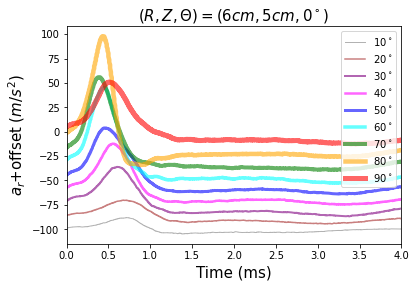

In [59]:
offset_time_close = [796.46, 567.58, 770.93, 577.32, 790.08, 582.74, 781.46, 579.23, 773.96]
offset_time_far = [805.40, 572.53, 779.54, 563.75, 791.52, 585.62, 764.86, 570.45, 764.22] 
offset_pulse =  np.linspace(100,0,9)
linewidth = np.linspace(1,5,9)

j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#6#0': # '#3#8#180'
        offset_time = find_onset(time[i], pulse[i])
        time_corrected = [t - offset_time for t in time[i]]
        pulse_corrected = [p - offset_pulse[j] for p in pulse[i]]
        plt.plot(time_corrected, pulse_corrected, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        j += 1
        print(offset_time)
plt.legend(loc = 1)
plt.xlim(0,4)
plt.ylabel("$a_r$+offset $(m/s^2)$", fontsize = 15)
plt.xlabel("Time (ms)", fontsize = 15)
plt.title("$(R,Z,\Theta)=(6cm,5cm,0^\circ)$", fontsize = 15)
plt.savefig("pulse_angle.png", dpi=400, bbox_inches='tight')

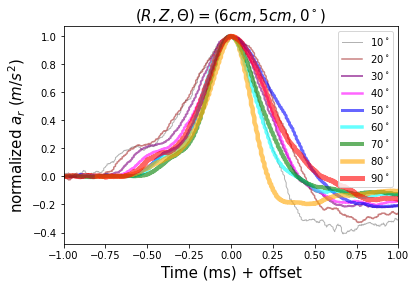

In [13]:
## will pulse broaden with impact angles? 
## let's first normalize the pulse
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#6#0': # '#3#8#180'
        offset_time = find_peak(time[i], pulse[i])
        time_corrected = [t - offset_time for t in time[i]] 
        pulse_normalized = pulse[i] / max(pulse[i]) # normalize pulse
        plt.plot(time_corrected, pulse_normalized, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        j += 1
plt.legend(loc = 1)
plt.xlim(-1,1)
plt.ylabel('normalized'+' '+"$a_r$ $(m/s^2)$", fontsize = 15)
plt.xlabel("Time (ms) + offset", fontsize = 15)
plt.title("$(R,Z,\Theta)=(6cm,5cm,0^\circ)$", fontsize = 15)
plt.savefig("pulse_angle.png", dpi=400, bbox_inches='tight')

# not much 

In [23]:
pv = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pv.append(vel[i][2])
    pv.append(vel[i][5])

tv = []
for i in range(len(data)):
    tv.append(vel[i][0])
    tv.append(vel[i][0])

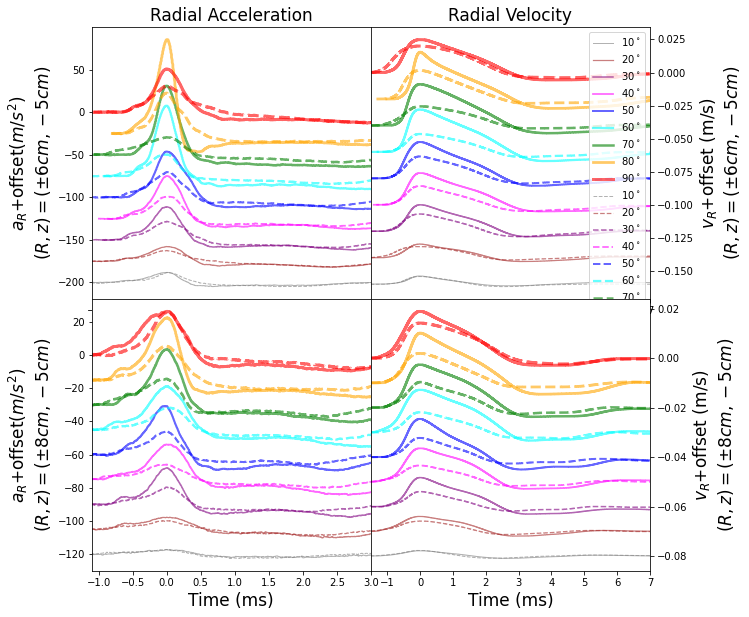

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
axs = axs.flatten()
offset_pulse =  np.linspace(200,0,9)
offset_pv =  np.linspace(0.16,0,9)
linewidth = np.linspace(1,3,9)

pulse = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pulse.append(data[i][2])
    pulse.append(data[i][5])
time = []
for i in range(len(data)):
    time.append(data[i][0])
    time.append(data[i][0])
pulse = [savgol_filter(i, window_length = 11, polyorder = 2) for i in pulse] # apply filter

pv = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pv.append(vel[i][2])
    pv.append(vel[i][5])

tv = []
for i in range(len(data)):
    tv.append(vel[i][0])
    tv.append(vel[i][0])

j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#6#0': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]] 
        axs[0].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[1].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        j += 1
        
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#3#6#180': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]]
        axs[0].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linestyle ='--',linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[1].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linestyle ='--',linewidth = linewidth[j])

        j += 1
    
offset_pulse =  np.linspace(120,0,9)
offset_pv =  np.linspace(0.08,0,9)   
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#8#0': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]] 
        axs[2].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[3].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        j += 1
        
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#3#8#180': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]]
        axs[2].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linestyle ='--',linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[3].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linestyle ='--',linewidth = linewidth[j])
#         axs[1].set_yticklabels([]) 
#         axs[3].set_yticklabels([]) 
        j += 1
    
        
        
axs[1].yaxis.tick_right()
axs[3].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[3].yaxis.set_label_position("right")
axs[1].set_ylabel(r"$v_R$"+"+offset (m/s)"+'\n'+r"$(R,z)=(\pm6cm,-5cm)$", fontsize=17)
axs[3].set_ylabel(r"$v_R$"+"+offset (m/s)"+'\n'+r"$(R,z)=(\pm8cm,-5cm)$", fontsize=17)
axs[1].legend(loc = 1)
axs[0].set_xlim(-1.1,3)
axs[1].set_xlim(-1.5,7)
axs[2].set_xlim(-1.1,3)
axs[3].set_xlim(-1.5,7)
axs[0].set_ylabel(r"$a_R$"+"+offset"+r"$(m/s^2)$"+'\n'+r"$(R,z)=(\pm6cm,-5cm)$", fontsize = 17)
axs[2].set_ylabel(r"$a_R$"+"+offset"+r"$(m/s^2)$"+'\n'+r"$(R,z)=(\pm8cm,-5cm)$", fontsize = 17)
axs[2].set_xlabel("Time (ms)", fontsize = 17)
axs[3].set_xlabel("Time (ms)", fontsize = 17)
axs[0].set_title('Radial Acceleration', fontsize = 17)
axs[1].set_title('Radial Velocity', fontsize = 17)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('pulse_shape.png', dpi=500, bbox_inches='tight')

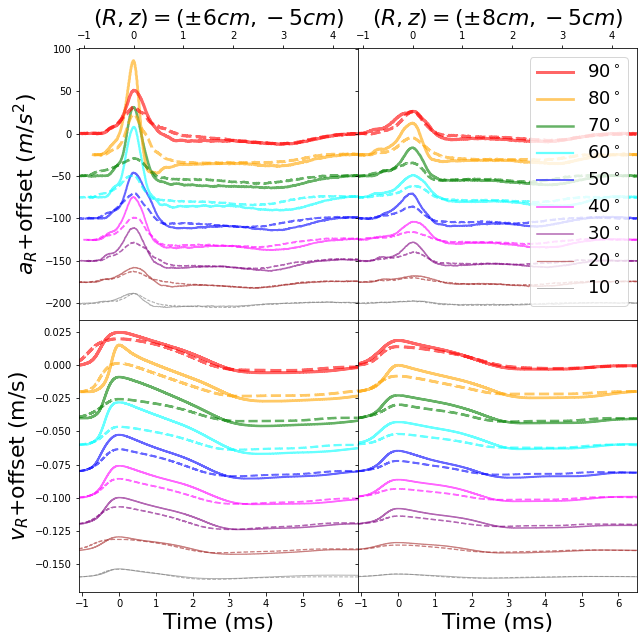

In [199]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10),sharey='row',sharex='row')
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
axs = axs.flatten()
offset_pulse =  np.linspace(200,0,9)
offset_pv =  np.linspace(0.16,0,9)
linewidth = np.linspace(1,3,9)

pulse = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pulse.append(data[i][2])
    pulse.append(data[i][5])
time = []
for i in range(len(data)):
    time.append(data[i][0])
    time.append(data[i][0])
pulse = [savgol_filter(i, window_length = 7, polyorder = 2) for i in pulse] # apply filter

pv = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pv.append(vel[i][2])
    pv.append(vel[i][5])

tv = []
for i in range(len(data)):
    tv.append(vel[i][0])
    tv.append(vel[i][0])

j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#6#0': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]] 
        axs[0].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[2].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        j += 1
        
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#3#6#180': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]]
        axs[0].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linestyle ='--',linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[2].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linestyle ='--',linewidth = linewidth[j])

        j += 1
    
# offset_pulse =  np.linspace(120,0,9)
# offset_pv =  np.linspace(0.08,0,9)   
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#8#0': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]] 
        axs[1].plot(tc, pc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[3].plot(tc, pvc, color = color_angle[i], alpha = 0.6, label = str(angle[i])+"$^\circ$", linewidth = linewidth[j])
        j += 1
        
j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#3#8#180': # '#3#8#180'
        pc = [p - offset_pulse[j] for p in pulse[i]]
        pvc = [p - offset_pv[j] for p in pv[i]]
        ot = find_peak(time[i], pc,'max')
        tc = [t - ot for t in time[i]]
        axs[1].plot(tc, pc, color = color_angle[i], alpha = 0.6, linestyle ='--',linewidth = linewidth[j])
        ot = find_peak(tv[i], pvc,'max')
        tc = [t - ot for t in tv[i]] 
        axs[3].plot(tc, pvc, color = color_angle[i], alpha = 0.6, linestyle ='--',linewidth = linewidth[j])
#         axs[1].set_yticklabels([]) 
#         axs[3].set_yticklabels([]) 
        j += 1
    
   
axs[0].xaxis.tick_top()
axs[1].xaxis.tick_top()

axs[2].set_ylabel(r"$v_R$"+"+offset (m/s)", fontsize=22)
axs[1].legend(loc = 1,prop = { "size": 15 })
axs[0].set_xlim(-1.1,4.5)
axs[2].set_xlim(-1.1,6.5)

axs[0].set_ylabel(r"$a_R$"+"+offset "+r"$(m/s^2)$", fontsize = 22)

axs[2].set_xlabel("Time (ms)", fontsize = 22)
axs[3].set_xlabel("Time (ms)", fontsize = 22)
axs[0].set_title(r"$(R,z)=(\pm6cm,-5cm)$", fontsize = 22)
axs[1].set_title(r"$(R,z)=(\pm8cm,-5cm)$", fontsize = 22)

# Get handles and labels of the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Reverse the order of handles and labels
handles = list(reversed(handles))
labels = list(reversed(labels))

# Create a new legend with reversed handles and labels
axs[1].legend(handles, labels,fontsize='large',loc=1,prop = { "size": 18 })

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('pulse_shape.png', dpi=500, bbox_inches='tight')

In [208]:
def pd(time, pulse):
    max_value = np.max(pulse)
    half_max = max_value / 2

    # Find the indices where the pulse crosses half maximum
    crossings = np.where(np.diff((pulse > half_max).astype(int)))[0]

    if len(crossings) < 2:
        # Unable to find FWHM
        return None
    # Calculate the FWHM
    fwhm = (time[crossings[1]] - time[crossings[0]])
    return fwhm

In [214]:
pulse = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pulse.append(data[i][2])
    pulse.append(data[i][5])
time = []
for i in range(len(data)):
    time.append(data[i][0])
    time.append(data[i][0])
pulse = [savgol_filter(i, window_length = 7, polyorder = 2) for i in pulse] # apply filter

pv = [] # each element represents an acc
# data structure
# [accf2,accf3, acc5, acc7, ....other angles]
for i in range(len(data)):
    pv.append(vel[i][2])
    pv.append(vel[i][5])

tv = []
for i in range(len(data)):
    tv.append(vel[i][0])
    tv.append(vel[i][0])

j = 0 
for i in range(np.shape(pulse)[0]):
    if template[i] == '#2#6#0': # '#3#8#180'
        print(pd(tv[i],pv[i]))
        


1.24
1.7799999999999998
1.89
1.94
1.89
2.04
1.95
1.5199999999999998
2.13


In [201]:
0.45999999999999996*2

0.9199999999999999